In [1]:
from math import sqrt

import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
from pywr.uncertainties.devices import METEX_M4650_CURRENT, METEX_M4650_VOLTAGE
from pywr.uncertainties.format import (
    rounded_uncertainty_with_nominal_value,
    shorthand_notation,
)
from pywr.uncertainties.uncertainty import uncertainty

KeyboardInterrupt: 

In [ ]:
def compute_uncertainties(df: pd.DataFrame) -> pd.DataFrame:
    """Compute uncertainties for the given DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with the data.

    Returns:
        pd.DataFrame: DataFrame with the data and uncertainties.
    """
    df["u(U)"] = df["U"].apply(
        lambda u: uncertainty(abs(u), 0.001, METEX_M4650_VOLTAGE)
    )
    df["u(I)"] = df["I"].apply(
        lambda i: uncertainty(abs(i), 0.001, METEX_M4650_CURRENT)
    )

    return df

In [ ]:
def format_sample_data(df: pd.DataFrame) -> pd.DataFrame:
    """Format the sample data.

    Args:
        df (pd.DataFrame): DataFrame with the data.

    Returns:
        pd.DataFrame: DataFrame with the data.
    """
    voltage_with_uncertainty = [
        rounded_uncertainty_with_nominal_value(u, uu)
        for u, uu in zip(df["U"], df["u(U)"])
    ]
    current_with_uncertainty = [
        rounded_uncertainty_with_nominal_value(i, ui)
        for i, ui in zip(df["I"], df["u(I)"])
    ]

    df["U"], df["u(U)"] = [u for u, _ in voltage_with_uncertainty], [
        uu for _, uu in voltage_with_uncertainty
    ]
    df["I"], df["u(I)"] = [i for i, _ in current_with_uncertainty], [
        ui for _, ui in current_with_uncertainty
    ]

    df = df.reindex(columns=["U", "u(U)", "I", "u(I)"])

    return df

In [ ]:
def get_sample_data(df: pd.DataFrame, step: int, count: int) -> pd.DataFrame:
    return df[df.index % step == 0][:count]

In [ ]:
df = pd.read_csv("data/vdsconst-7.dat", delimiter="\s+", header=0)
df = compute_uncertainties(df)
df = get_sample_data(df, 15, 10)
df = format_sample_data(df)
df.reset_index(drop=True, inplace=True)

display(df)
df.to_csv("vdsc-7.csv")

,U,u(U),I,u(I)
0,-3316.00,0.97,0.0000,0.0017
1,-3222.00,0.95,0.0000,0.0017
2,-3197.00,0.94,0.0000,0.0017
3,-3086.00,0.91,0.0100,0.0017
4,-3027.00,0.89,0.0000,0.0017
5,-2941.00,0.87,0.0100,0.0017
6,-2826.00,0.83,0.0300,0.0017
7,-2727.00,0.80,0.0600,0.0017
8,-2680.00,0.79,0.0900,0.0017
9,-2595.00,0.77,0.1600,0.0018


In [ ]:
df = pd.read_csv("data/vgconst-1.dat", delimiter="\s+", header=0)
df = compute_uncertainties(df)
df = get_sample_data(df, 15, 10)
df = format_sample_data(df)
df.reset_index(drop=True, inplace=True)

display(df)
df.to_csv("vgc-1.csv")

,U,u(U),I,u(I)
0,9.0,1.7,0.0100,0.0017
1,87.0,1.8,0.33000,0.00059
2,237.000,0.086,0.8600,0.0015
3,452.00,0.15,1.4900,0.0026
4,590.00,0.19,1.9000,0.0033
5,730.00,0.23,2.26000,0.00056
6,926.00,0.28,2.66000,0.00063
7,1164.00,0.35,3.05000,0.00070
8,1479.00,0.44,3.40000,0.00076
9,1844.00,0.55,3.66000,0.00081


In [ ]:
def calculate_gds_uncertainty(id_: float, uds: float, uid: float, uuds: float) -> float:
    return sqrt(((1 / uds) * uid) ** 2 + (((id_ / uds**2) * uuds) ** 2))


def conductance(df: pd.DataFrame, value: float) -> pd.DataFrame:
    nearest_rows = df.loc[(df["U"] - value).abs().argsort()[:10]]
    nearest_rows.reset_index(drop=True, inplace=True)

    X = nearest_rows["U"].values
    X = sm.add_constant(X)
    y = nearest_rows["I"].values
    model = sm.OLS(y, X).fit()

    voltage, vu = nearest_rows["U"][5], nearest_rows["u(U)"][5]
    current, iu = nearest_rows["I"][5], nearest_rows["u(I)"][5]

    a = model.params[1] * 1000
    uncertainty = calculate_gds_uncertainty(current, voltage, iu, vu) * 1000
    return shorthand_notation(a, uncertainty)

# Tables

## Conductance table

In [ ]:
voltages = [
    ("0", 0),
    ("1", 1000),
    ("2", 2000),
    ("3", 3000),
    ("4", 4000),
    ("5", 5000),
    ("6", 6000),
]
dfs = [
    pd.read_csv(path, delimiter="\s+", header=0)
    for path in [
        "data/vgconst-0.dat",
        "data/vgconst-0.5.dat",
        "data/vgconst-1.dat",
        "data/vgconst-1.5.dat",
        "data/vgconst-2.dat",
    ]
]

o = {key: [] for key, _ in [*voltages, ("Ugs", 0)]}
for i, df in enumerate(dfs):
    data = compute_uncertainties(df)
    o["Ugs"].append(i / (-2))
    for h, v in voltages:
        con = conductance(data, v)
        o[h].append(con)

output = pd.DataFrame(o)
output = output.reindex(columns=["Ugs", "0", "1", "2", "3", "4", "5", "6"])

output.to_csv("conductance.csv", index=False, sep=",")

display(output)

,Ugs,0,1,2,3,4,5,6
0,-0.0,5.73(28),3.5168(18),1.3966(13),0.43646(97),0.17859(74),0.06350(60),0.03925(50)
1,-0.5,4.73(23),2.5870(14),0.82098(99),0.25021(68),0.09456(52),0.05095(42),0.01212(36)
2,-1.0,3.93(31),1.7481(11),0.40660(70),0.15387(49),0.07069(38),0.02968(31),0.05377(25)
3,-1.5,2.81(12),0.8568(34),0.14165(45),0.03950(30),0.02246(23),0.03348(19),0.00020(16)
4,-2.0,1.778(95),0.3123(17),0.11408(91),0.04401(66),0.01482(51),0.01594(41),0.02179(35)


## Transconductance table

In [ ]:
voltages = [
    ("-0.4", -400),
    ("-0.8", -800),
    ("-1.2", -1200),
    ("-1.6", -1600),
    ("-2", -2000),
    ("-2.4", -2400),
]
dfs = [
    pd.read_csv(path, delimiter="\s+", header=0)
    for path in ["data/vdsconst-7.dat", "data/vdsconst-9.dat", "data/vdsconst-11.dat"]
]

result_dict = {key: [] for key, _ in [*voltages, ("Ugs", 0)]}
for df, i in zip(dfs, [7, 9, 11]):
    data = compute_uncertainties(df)
    result_dict["Ugs"].append(i)
    for h, v in voltages:
        result_dict[h].append(conductance(data, v))

output = pd.DataFrame(result_dict)
output = output.reindex(columns=["Ugs", "-0.4", "-0.8", "-1.2", "-1.6", "-2", "-2.4"])

output.to_csv("transconductance.csv", index=False, sep=",")

display(output)

,Ugs,-0.4,-0.8,-1.2,-1.6,-2,-2.4
0,7,4.3094(59),3.7868(24),3.5396(10),2.96403(52),2.19536(98),1.44746(33)
1,9,4.1892(68),4.1701(24),3.5352(11),2.95461(57),2.29436(97),1.40071(27)
2,11,4.0422(61),3.8045(24),3.4958(11),2.73211(53),2.3444(11),1.36794(34)


# Plots

In [ ]:
def voltage_current_plot_wrapper(path: str, title: str, color: str, show: bool = True):
    df = pd.read_csv(path, delimiter="\s+", header=0)
    df = compute_uncertainties(df)

    if show:
        plt.figure()

    plt.errorbar(
        df["U"],
        df["I"],
        xerr=df["u(U)"],
        yerr=df["u(I)"],
        color=color,
        fmt=".",
        capsize=2,
        markersize=0,
    )

    plt.xlabel("U [mV]")
    plt.ylabel("I [mA]")
    plt.title(title)
    plt.grid(True)

    if show:
        plt.show()

### $U_gs = 0V$

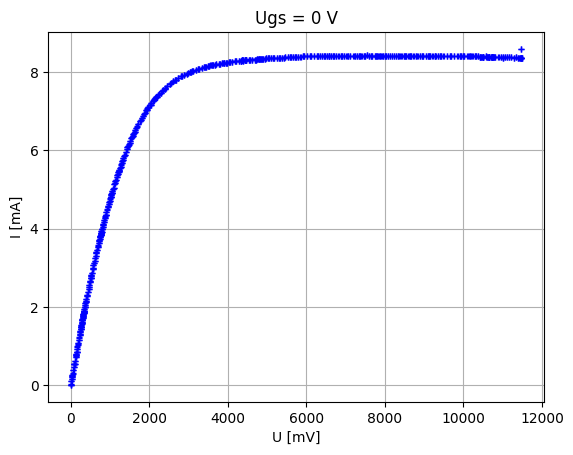

In [ ]:
voltage_current_plot_wrapper("data/vgconst-0.dat", "Ugs = 0 V", "blue")

### $U_gs = 0.5V$

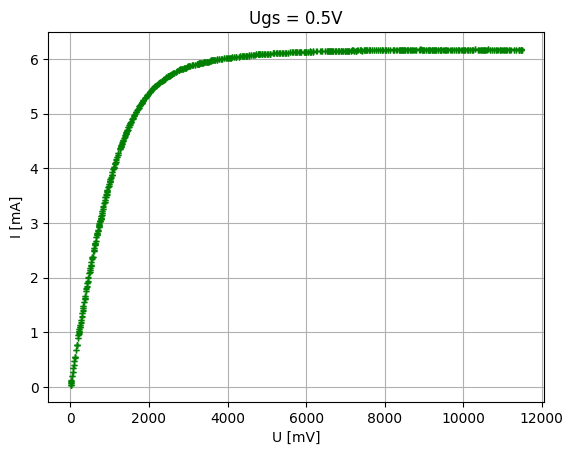

In [ ]:
voltage_current_plot_wrapper("data/vgconst-0.5.dat", "Ugs = 0.5V", "green")

### $U_gs = 1V$

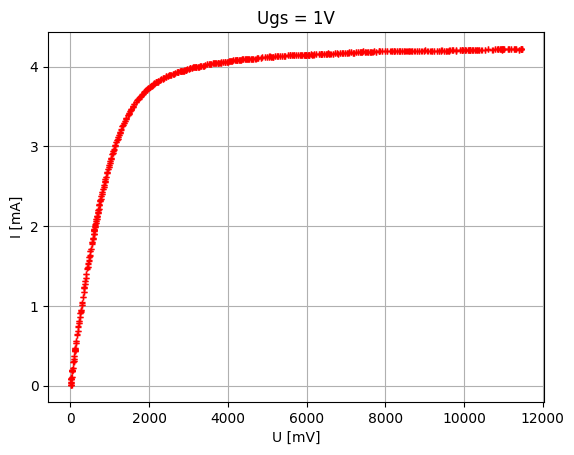

In [ ]:
voltage_current_plot_wrapper("data/vgconst-1.dat", "Ugs = 1V", "red")

### $U_gs = 1.5V$

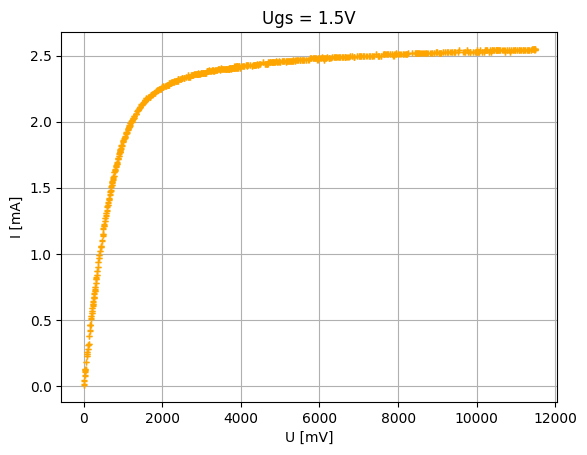

In [ ]:
voltage_current_plot_wrapper("data/vgconst-1.5.dat", "Ugs = 1.5V", "orange")

### $U_gs = 2V$

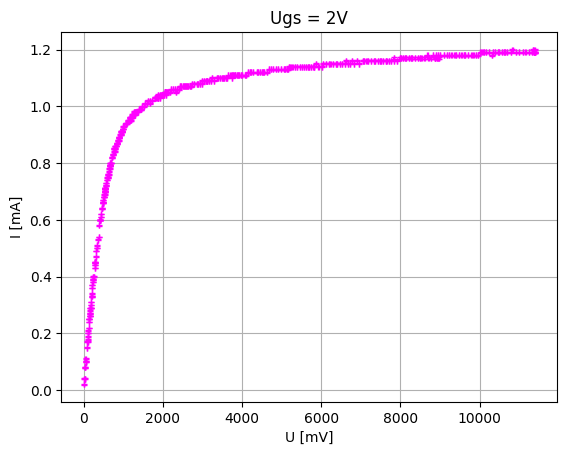

In [ ]:
voltage_current_plot_wrapper("data/vgconst-2.dat", "Ugs = 2V", "magenta")

## $U_{ds} = 7V$

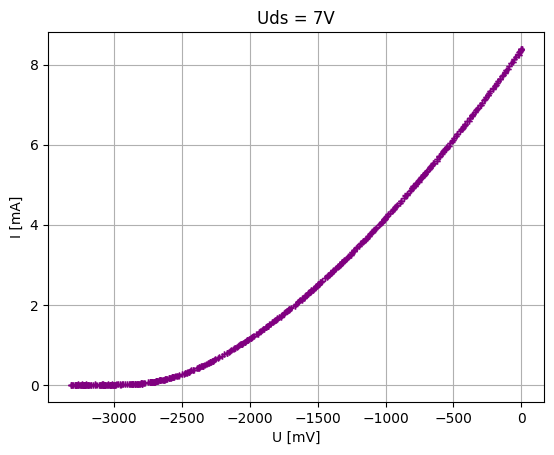

In [ ]:
voltage_current_plot_wrapper("data/vdsconst-7.dat", "Uds = 7V", "purple")

## $U_{ds} = 9V$

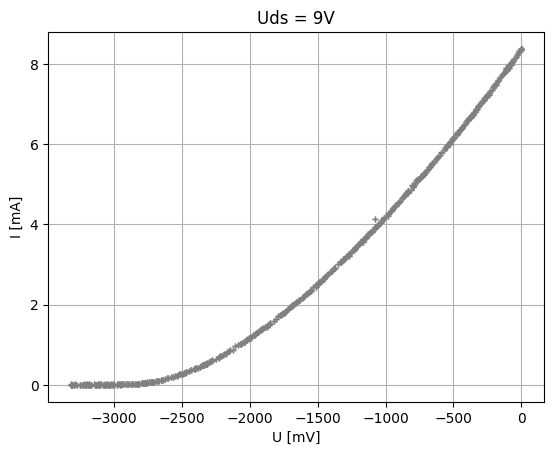

In [ ]:
voltage_current_plot_wrapper("data/vdsconst-9.dat", "Uds = 9V", "gray")

## $U_{ds} = 11V$

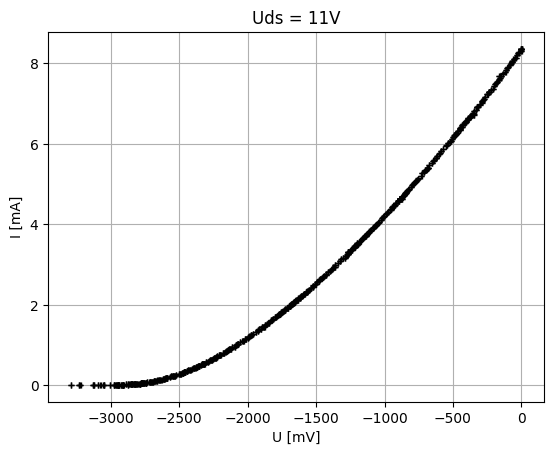

In [ ]:
voltage_current_plot_wrapper("data/vdsconst-11.dat", "Uds = 11V", "black")

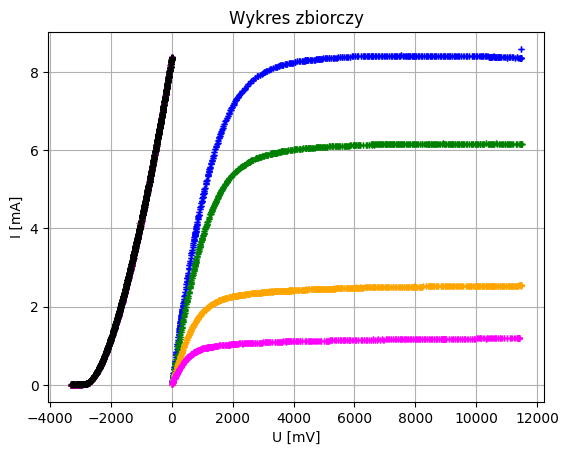

In [ ]:
plt.figure()

voltage_current_plot_wrapper("data/vgconst-0.dat", "Vg = 0 V", "blue", show=False)
voltage_current_plot_wrapper("data/vgconst-0.5.dat", "Vg = 0.5V", "green", show=False)
voltage_current_plot_wrapper("data/vgconst-1.5.dat", "Vg = 1.5V", "orange", show=False)
voltage_current_plot_wrapper("data/vgconst-2.dat", "Vg = 2V", "magenta", show=False)
voltage_current_plot_wrapper("data/vdsconst-9.dat", "Vds = 9V", "gray", show=False)
voltage_current_plot_wrapper("data/vdsconst-7.dat", "Vds = 7V", "purple", show=False)
voltage_current_plot_wrapper("data/vdsconst-11.dat", "Vds = 11V", "black", show=False)
voltage_current_plot_wrapper("data/vdsconst-11.dat", "Vds = 11V", "black", show=False)

plt.title("Wykres zbiorczy")

plt.show()